In [8]:
import pandas as pd
df = pd.read_csv('data_analysis_done.csv')
df.head()

,Unnamed: 0,road,town,location,vehicles,accident_types,hospital,injuries,brands,day,...,year,has_motorcycle,has_car,has_pedestrian,has_van,injury_severity,is_grievous,day_num,is_weekend,severity_label
0,0,Triq il-Belt Valletta,Iż-Żurrieq,"('Triq il-Belt Valletta', 'Iż-Żurrieq')","['Car', 'Motorcycle']","['Collision', 'Accident']",['Mater Dei'],[],"['Toyota', 'Piaggio']",Thursday,...,2025,1,1,0,0,0,0,3,0,None/Unknown
1,1,Triq Dawret il-Gudja,Il-Gudja,"('Triq Dawret il-Gudja', 'Il-Gudja')","['Car', 'Motorcycle']","['Collision', 'Accident']",['Mater Dei'],['Grievous'],"['Honda', 'Kawasaki']",Friday,...,2025,1,1,0,0,3,1,4,0,Grievous
2,2,Valley Road,Ħal Qormi,"('Valley Road', 'Ħal Qormi')","['Car', 'Motorcycle']","['Collision', 'Accident']",['Mater Dei'],['Grievous'],"['Honda', 'Ford']",Monday,...,2025,1,1,0,0,3,1,0,0,Grievous
3,3,Triq Dawret Ħal Għaxaq,Ħal Ghaxaq,"('Triq Dawret Ħal Għaxaq', 'Ħal Ghaxaq')","['Car', 'Motorcycle']","['Collision', 'Accident']",['Mater Dei'],['Grievous'],"['Malaguti', 'Volvo']",Wednesday,...,2025,1,1,0,0,3,1,2,0,Grievous
4,4,Triq il-Buqana,Ir-Rabat,"('Triq il-Buqana', 'Ir-Rabat')","['Car', 'Motorcycle']","['Collision', 'Accident']",['Mater Dei'],['Grievous'],"['Kia', 'Kymco']",Monday,...,2025,1,1,0,0,3,1,0,0,Grievous


In [20]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Drop raw text columns
drop_cols = [
    'Unnamed: 0', 'road', 'location', 'town', 'vehicles', 'accident_types', 'hospital', 
    'injuries', 'brands', 'time', 'weather_matched_hour_utc', 'vehicles_parsed', 
    'accident_types_parsed', 'hospital_parsed', 'injuries_parsed', 'brands_parsed', 
    'severity_label', 'injury_severity', 'is_grievous', 'day', 'num_brands'
]

# Separate Features (X) and Target (y)
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['is_grievous']

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify Numerical and Categorical columns
num_features = X.select_dtypes(include=['number']).columns.tolist()
    
# Create Preprocessing Pipeline (Scale Numerical, Encode Categorical)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
    ],
    verbose_feature_names_out=False
)

# Apply Preprocessing
X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
X_test_scaled = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

print("Processed Train Shape:", X_train_scaled.shape)
print("Processed Test Shape:", X_test_scaled.shape)

Processed Train Shape: (88, 25)
Processed Test Shape: (23, 25)


In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf', 'linear', 'sigmoid']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,            # 5-fold cross-validation
    n_jobs=-1,       # Use all available cores
    verbose=1,
    scoring='accuracy'
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Display results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# The best model is now stored in grid_search.best_estimator_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.7163


In [22]:
from sklearn.svm import SVC

# Initialize the model with the best parameters found
svm_clf = SVC(C=100, gamma=0.001, kernel='rbf', probability=True, random_state=42)

# Fit the model to the training data
svm_clf.fit(X_train_scaled, y_train)

# Generate predictions
y_train_pred = svm_clf.predict(X_train_scaled)
y_test_pred = svm_clf.predict(X_test_scaled)



In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    roc_auc_score, 
    cohen_kappa_score, 
    matthews_corrcoef
)

y_test_proba = svm_clf.predict_proba(X_test_scaled)[:, 1]

print("### Model Evaluation Metrics ###")
print("-" * 30)
print(f"Training Accuracy:     {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Accuracy:              {accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC Score:         {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Cohen's Kappa:         {cohen_kappa_score(y_test, y_test_pred):.4f}")
print(f"Matthews Corr. Coeff:  {matthews_corrcoef(y_test, y_test_pred):.4f}")
print("-" * 30)
print("\n### Classification Report ###")
print(classification_report(y_test, y_test_pred))

### Model Evaluation Metrics ###
------------------------------
Training Accuracy:     0.8182
Accuracy:              0.6522
ROC AUC Score:         0.5446
Cohen's Kappa:         0.0213
Matthews Corr. Coeff:  0.0244
------------------------------

### Classification Report ###
              precision    recall  f1-score   support

           0       0.33      0.14      0.20         7
           1       0.70      0.88      0.78        16

    accuracy                           0.65        23
   macro avg       0.52      0.51      0.49        23
weighted avg       0.59      0.65      0.60        23



<Figure size 800x600 with 0 Axes>

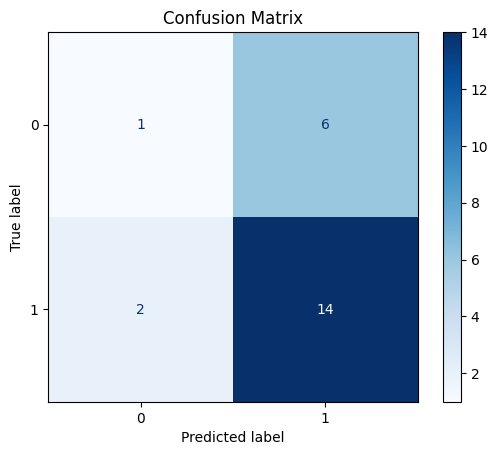

<Figure size 800x600 with 0 Axes>

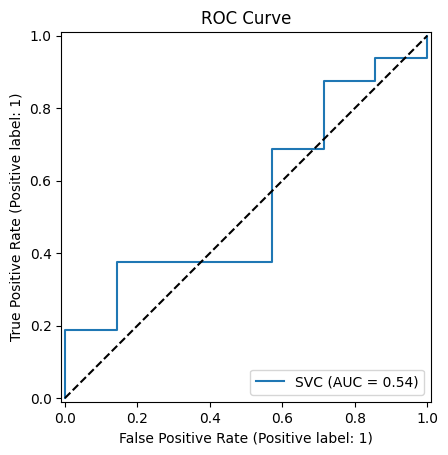

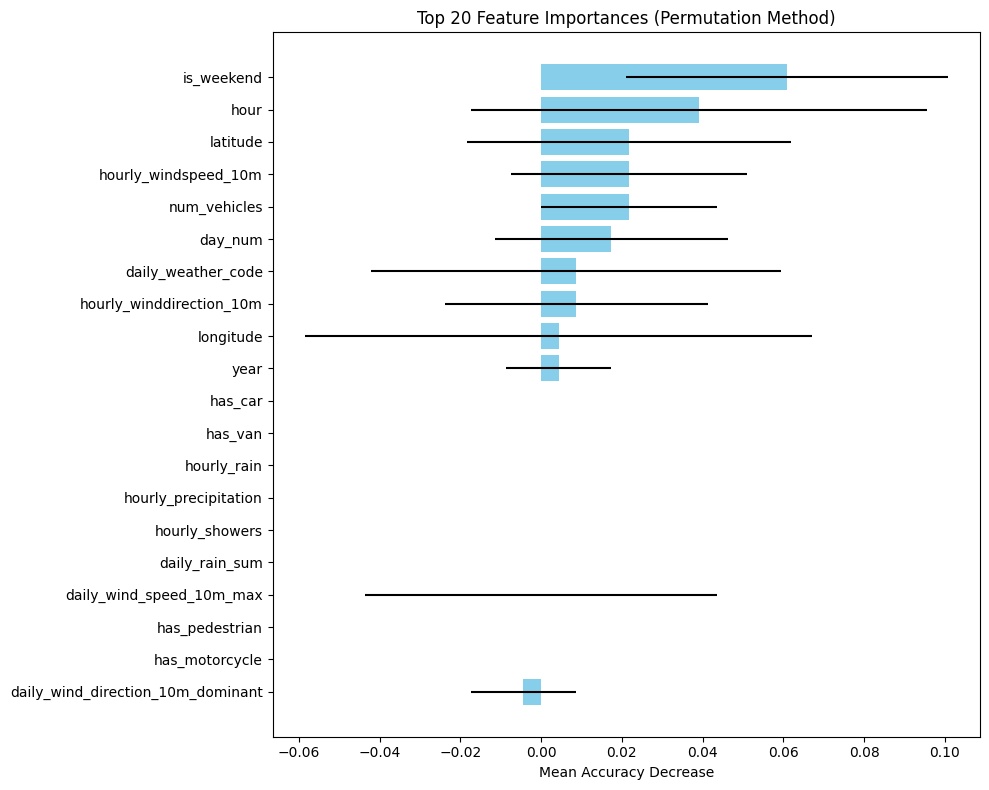

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(svm_clf, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix")


# 2. ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(svm_clf, X_test_scaled, y_test)
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1], 'k--') # Add diagonal line for random guess

# 3. Feature Importance (Permutation Importance for SVM with RBF Kernel)
# Note: SVM with RBF kernel does not have direct coefficients, so we use Permutation Importance
perm_importance = permutation_importance(svm_clf, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Organize into a DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})

# Sort and take top 20
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(fi_df['Feature'], fi_df['Importance'], xerr=fi_df['Std'], color='skyblue')
plt.gca().invert_yaxis() # Highest importance at top
plt.title("Top 20 Feature Importances (Permutation Method)")
plt.xlabel("Mean Accuracy Decrease")
plt.tight_layout()
